In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

sns.set_style('white')
sns.set_context('talk')

np.random.seed(123)

## Simple Example for Kalman Filters
This work is based off [The Extended Kalman Filter](https://home.wlu.edu/~levys/kalman_tutorial/)

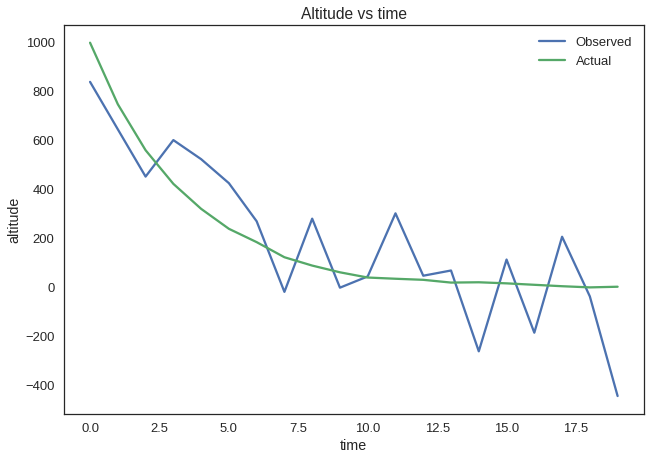

In [19]:
#position decay rate
decayRate = 0.75
numberOfPoints = 20
altitudeInitialValue = 1000

#Noise Properties
#noise in my observations
observationStd = 200
#noise in the process (plane does not descend smoothly)
processStd = 5

#Actual positions
time = np.arange(0, numberOfPoints)
def constructX(list, growth, itMax, it, processStd):
    if it >= itMax:
        return list;
    else: 
        it+=1
        #determining the jitter in the motion of the aircraft
        processNoise = np.random.normal(0, processStd)
        
        #the next altitude step
        newAltitude = list[-1]*growth+processNoise

        list.append(newAltitude)
        return constructX(list, growth, itMax, it, processStd);
        
#I think this would be more realistic if it was a fraction of the altitude, rather than an absolute number
observationNoise = np.random.normal(0, observationStd, numberOfPoints)

#this will calculate the position, including jitter due to process noise
actualAltitude = constructX([altitudeInitialValue], decayRate, numberOfPoints, 1, processStd)

observerAltitude = actualAltitude + observationNoise

ax = plt.subplot()
ax.plot(time, observerAltitude)
ax.plot(time, actualAltitude)
ax.legend(['Observed', 'Actual'])
plt.xlabel("time")
plt.ylabel("altitude")
plt.title("Altitude vs time")
plt.show()


Prediction and update equations

In [28]:
#Prediction
#evolves our state on step forward in time.  That is, is our prediction for the next timestep, given the value at the 
#prior time step
def statePrediction(priorEstimate):
    return priorEstimate*decayRate

def covariancePrediction(priorCovariance):
    return decayRate*priorCovariance*decayRate + processStd

#---------------------------------------------------------------
#Updatre equations
def measurementResidual(observedAltitude, predictedAltitude):
    return observedAltitude - predictedAltitude

#because the  observation covariance and the process covariance are statistically independent, and linearly related 
#observation = process*observationModel + observationNoise, the observation covariance will be the sum of the process covariance
#and the covariance of the noise associated with the observation mechanism 
def residualCovariance(predictedCovariance):
    return observationStd + predictedCovariance

def kalmanGain(predictedCovariance):
    return predictedCovariance/residualCovariance(predictedCovariance)

#update of the state estimate, taking into account our prior knowledge
def stateUpdate(predictedState, kalmanGain, measurementResidual):
    return predictedState + kalmanGain*measurementResidual

def covarianceUpdate(predictedCovariance, kalmanGain):
    return (1-kalmanGain)*predictedCovariance




In [29]:
#function takes a new observation, and old values, and produces a new kalman estimate (appending the new value to the)
#old filtered obsevrations
def kalmanApplication(newObservation, oldObservations, oldFilteredObservations, oldCovarPredict, oldCovarUpdate):
    if not oldObservations:
        #this is the first, when we have no prior information 
        oldObservations = [newObservation]
        oldFilteredObservations = [newObservation]
        oldCovarPredict = [1]
        oldCovarUpdate = [1]
        return newObservation, oldObservations, oldFilteredObservations, oldCovarPredict, oldCovarUpdate
    else:
        predictedState = statePrediction(oldFilteredObservations[-1])
        predictedCovariance = covariancePrediction(oldCovarUpdate[-1])
        residualAlt = measurementResidual(newObservation, predictedState)
        kG = kalmanGain(predictedCovariance)
        updatedState = stateUpdate(predictedState, kG, residualAlt)
        covarUpdate = covarianceUpdate(predictedCovariance, kG)

        #update our lists
        oldObservations.append(newObservation)
        oldFilteredObservations.append(updatedState)
        oldCovarPredict.append(predictedCovariance)
        oldCovarUpdate.append(covarUpdate)
        return updatedState, oldObservations, oldFilteredObservations, oldCovarPredict, oldCovarUpdate
        
        
        

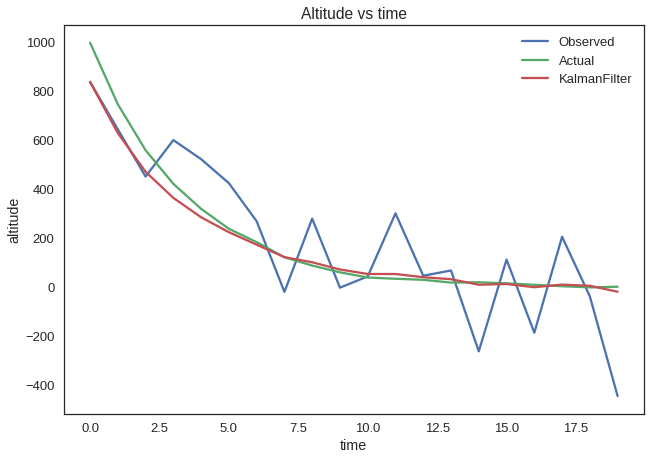

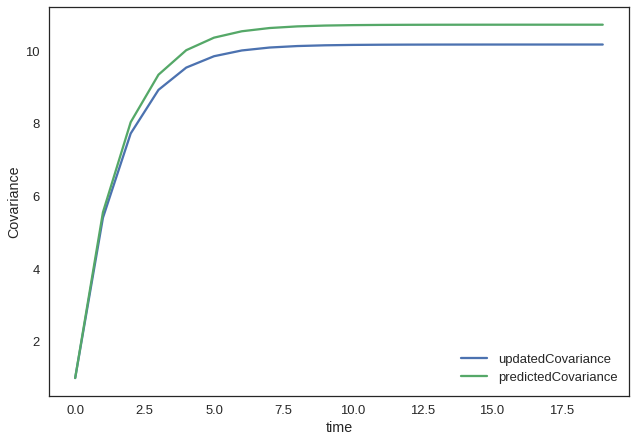

In [30]:
oldObservations = []
oldFilteredObservations = []
oldCovarPredict = []
oldCovarUpdate = []

#loop over our observations, determine the corrections due to the kalman filtert
for observation in observerAltitude:
    (update, oldObservations, oldFilteredObservations, oldCovarPredict, oldCovarUpdate) = \
       kalmanApplication(observation, oldObservations, oldFilteredObservations, oldCovarPredict, oldCovarUpdate)
        
#ok, how well did we do
ax = plt.subplot()
ax.plot(time, observerAltitude)
ax.plot(time, actualAltitude)
ax.plot(time, oldFilteredObservations)
ax.legend(['Observed', 'Actual', "KalmanFilter"])
plt.xlabel("time")
plt.ylabel("altitude")
plt.title("Altitude vs time")
plt.show()

ay = plt.subplot()
plt.xlabel("time")
plt.ylabel("Covariance")
ay.plot(time, oldCovarUpdate)
ay.plot(time, oldCovarPredict)
ay.legend(['updatedCovariance', 'predictedCovariance'])
plt.show()